# Authors
* Georgios Nikolaou    - 1115202000154 </br>
* Styliani Fragkiadaki - 1115201900205

# Importing essential libraries

In [ ]:
import pickle
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 700) 
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import time
from collections import Counter


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')


from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
!pip3 install pyLDAvis
import pyLDAvis
from gensim.models import CoherenceModel
import pyLDAvis.gensim_models as gensimvis

import warnings
warnings.filterwarnings("ignore") 

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
     |████████████████████████████████| 1.7 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=ea5c464878dff1959815c2e6f5302f0bb1bec28818aa708274841563be660064
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


# Mount drive to store and have access to the files

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')
ROOT_PATH = 'gdrive/My Drive/tede_data/'  

VECTORIZERS = ROOT_PATH + 'vectorizers/'
DATASETS = ROOT_PATH + 'datasets/'
GLOVE = ROOT_PATH + 'glove/'

Mounted at /content/gdrive


# Utility functions

In [ ]:
def write_data(path, obj):
    with open(path, 'wb') as file:
        pickle.dump(obj, file)

def load_data(*paths):
    assert(paths)
    to_return = [pd.read_pickle(path) for path in paths]
    return to_return if len(to_return) != 1 else to_return[0]

def load_glove_model(path):
    glove_model = {}
    with open(path,'r') as f:
        for line in f:
            tokens = line.split()
            glove_model[tokens[0]] = np.array(tokens[1:], dtype=np.float64)

    return glove_model

# Functions for plotting data

In [ ]:
def pie_plot(values, lables, title):
    total = sum(values)
    perc = [v / total for v in values]
    plt.pie(perc, labels = lables)
    plt.title(title)
    plt.show() 

def hor_bar_plot(height, bars, title):
    y_pos = np.arange(len(bars))
    plt.barh(y_pos, height)
    plt.yticks(y_pos, bars)
    plt.title(title)
    plt.show()

def line_plot(x, y, title):
    plt.plot( 'x_values', 'y_values', 
              data=pd.DataFrame({'x_values': x, 'y_values': y }), color='skyblue')
    plt.title(title)
    plt.show()

# Question 1
Lowercase the letters, remove mentions (@), hashtags (#) and links and then only keep the lower case english letters (removes emojis etc).
This removes the numbers as well but they are not really important to understand the sentiment of the tweet.

We finally remove the stopwords (the, and, ...) and we get the cleaned tweet

In [ ]:
def clean_tweets(tweets):
    new_tweets = []
    sw = stopwords.words('english') 
    sw.remove('not')
    for tweet in tweets:
        # Remove mentions, hashtags and links, on the now lowercase text
        new_tweet = re.sub(r"(@\S+)|(#\S+)|(http\S+)|(www.\S+)","", tweet.lower())

        # Remove every character that is not a letter
        new_tweet = re.sub("[^a-z]"," ", new_tweet)

        # Remove stopwords
        new_tweet = ' '.join([word for word in word_tokenize(new_tweet) if not word in sw])

        new_tweets.append(new_tweet)

    return new_tweets

In [ ]:
df = load_data(DATASETS + 'data_set.pkl')
df['text'] = clean_tweets(df['text'])
write_data(DATASETS + 'data_set_clean.pkl', df)

# Initial train-test split
We split the data into 2 subsets, the training set that will be used to finetune the models and the test set that will be used to evaluate the final model that will have been fitted in all of the training set data.

In [ ]:
df = load_data(DATASETS + 'data_set_clean.pkl')

train_data, test_data = train_test_split(df, test_size=0.2, random_state=1, stratify=df['sentiment'].values)
write_data(DATASETS + 'train.pkl', train_data)
write_data(DATASETS + 'test.pkl', test_data)

# Question 2


In [ ]:
def sentiments_distr(dataframe, title, feelings = ['NEG', 'NEU', 'POS']):
    feelings_list = list(dataframe['sentiment'].values)
    counts = [feelings_list.count(f) for f in feelings]

    pie_plot(counts, tuple(feelings), title)

def find_most_frequent(dataframe, title, most_frequent = 5, sentiment = None):
    tweets = dataframe['text']
    sentiments = dataframe['sentiment']
    subset = tweets if sentiment == None else [t for (t,s) in zip(tweets, sentiments) if s == sentiment]

    words = (' '.join(subset)).split()
    c = Counter(words)
    frequent = c.most_common(most_frequent)

    hor_bar_plot([c[1] for c in frequent], tuple([c[0] for c in frequent]), title)

In [ ]:
df = load_data(DATASETS + 'train.pkl')

## i. Sentiment distribution of tweets

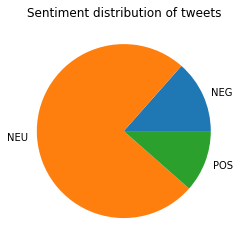

In [ ]:
sentiments_distr(df, "Sentiment distribution of tweets")

## ii. Most frequent words of tweets

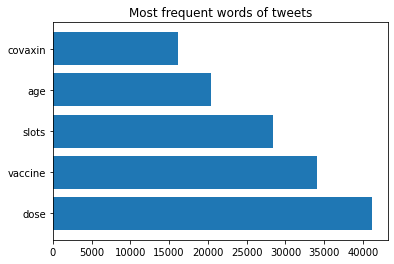

In [ ]:
find_most_frequent(df, "Most frequent words of tweets")

## iii. Most frequent words of tweets depending on their sentiment

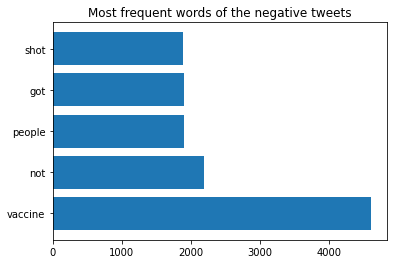

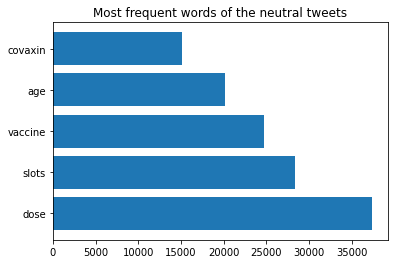

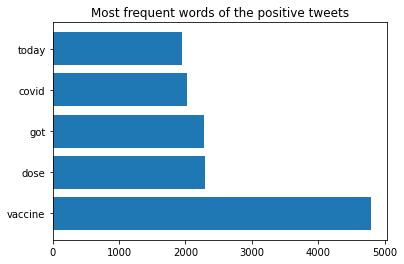

In [ ]:
find_most_frequent(df, "Most frequent words of the negative tweets", sentiment = 'NEG')
find_most_frequent(df, "Most frequent words of the neutral tweets", sentiment = 'NEU')
find_most_frequent(df, "Most frequent words of the positive tweets", sentiment = 'POS')

## Sentiment distributions depending on vaccine

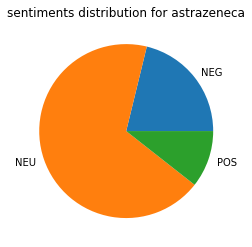

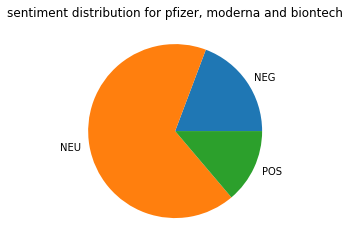

In [ ]:
astra_df = df[df['text'].str.contains('astrazeneca') == True]
rest_vacc_df = df[df['text'].str.contains('moderna|pfizer|biontech') == True]

sentiments_distr(astra_df, 'sentiments distribution for astrazeneca')
sentiments_distr(rest_vacc_df, 'sentiment distribution for pfizer, moderna and biontech')

## v. Monthly tweet count

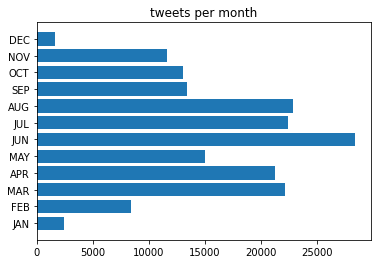

In [ ]:
df['date'] = pd.to_datetime(df['date'])
grouped = df.groupby([df['date'].dt.month]).agg('count')

counts = grouped['id'].to_list()
months = ('JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC')

hor_bar_plot(counts, months, 'tweets per month')

We observe that when big news about COVID-19 are announced, the number of tweets grows by a lot. We did some research on reliable sourses, and here are some interesting and noteworthy finds:

June 2021 (1st in tweets) : Delta variant, a more deadly mutation of COVID-19 emerges in most countries of the world and it seems that even vaccined people could be in danger [https://www.nytimes.com/2021/06/22/health/delta-variant-covid.html] 

August 2021 (2nd in tweets) : Official FDA approval of the Pfizer vaccine. Pro-vaccine VS anti-vaccine conflict grows bigger and bigger [https://www.immunize.org/timeline/] 

March 2020 (4th in tweets) : WHO characterizes COVID-19 as a pandemic, and the first lockdowns are emerging worldwide. [https://www.yalemedicine.org/news/covid-timeline]

## vi. Some observations of the data

In [ ]:
def sentiment_correlation(dataframe, title, column='retweets', sentiments = ['NEG', 'NEU', 'POS']):
    sentiment_map = {'NEG' : 0, 'NEU' : 0, 'POS': 0}
    sentiment_count = {'NEG' : 0, 'NEU' : 0, 'POS': 0}
    for ind in dataframe.index:
        sentiment_map[dataframe['sentiment'][ind]] += dataframe[column][ind]
        sentiment_count[dataframe['sentiment'][ind]] += 1

    # find averages
    ratio = [sentiment_map[key] / sentiment_count[key] for key in sentiment_map.keys()]
    print([(key, sentiment_map[key] / sentiment_count[key]) for key in sentiment_map.keys()])

    hor_bar_plot(ratio, sentiments, title)

[('NEG', 1.9179028652712864), ('NEU', 2.3711930972055946), ('POS', 3.7599179858859433)]


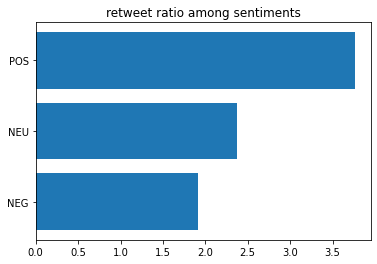

In [ ]:
sentiment_correlation(df, 'retweet ratio among sentiments')

The positive tweets get about 60% more retweets than neutral and 95% (!) more than negative tweets.

We would expect that more controversial takes (positive or negative) would get the most retweets by quite a margin.

But it appears that in these trying times, people did not want negativity, they needed to feel like things were getting better and this is reflected on their retweets.

[('NEG', 6.45954074375127), ('NEU', 10.142545332437878), ('POS', 20.792246805264163)]


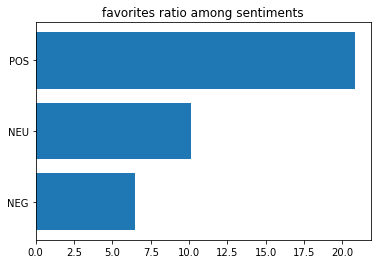

In [ ]:
sentiment_correlation(df, 'favorites ratio among sentiments', column='favorites')

The above statement is supported by the ratio of favorites on the different tweets (meaning how much people liked the tweet), where positive tweets are favorited twice as much as the neutral tweets and three times as much as the negative tweets, which highlights the need people have had for positivity

# Question 3

In [ ]:
MAX_DF = 1.0
MIN_DF = 2
MAX_FEATURES = 1000

def prepare_emb(tweets, model_path):
    model = pd.read_pickle(model_path)
    vectorized = []
    dims = len(list(model.values())[0])

    for tweet in tweets:
        vectors = [model[word] for word in tweet.split() if word in model]
        vector = (sum(vectors) / len(vectors)) if vectors else np.zeros((dims,))
        vectorized.append(vector)

    return vectorized 

def prepare_vector(tweets, vectorizer_path):
    vectorizer = load_data(vectorizer_path)
    return vectorizer.transform(tweets)

def fit_vectorizer(tweets, method, max_df=MAX_DF, min_df=MIN_DF, max_features=MAX_FEATURES):
    vectorizer = method(max_df=max_df, min_df=min_df, max_features=max_features)
    vectorizer.fit(tweets)
    return vectorizer

def transform_data(tweets, vec):
    return vec.transform(tweets)

def fit_transform_vectorizer(tweets, method, max_df=MAX_DF, min_df=MIN_DF, max_features=MAX_FEATURES):
    vectorizer = method(max_df=max_df, min_df=min_df, max_features=max_features)
    return vectorizer.fit_transform(tweets)

Fit the vectorizers to the training set tweets and store them for future use

For the word embeddings we use the pretrained glove model and therefore we don't have to do anything for that

In [ ]:
df = load_data(DATASETS + 'train.pkl')

write_data(VECTORIZERS + 'bow.pkl', fit_vectorizer(df['text'], method=CountVectorizer))
write_data(VECTORIZERS + 'tf_idf.pkl', fit_vectorizer(df['text'], method=TfidfVectorizer))

Create the representations (bow, td-idf, word embeddings) with the vectorizers we have for both the training set and the test set and store them for future use

In [ ]:
write_data(VECTORIZERS + 'bow_train_vectorized.pkl', prepare_vector(df['text'], VECTORIZERS + 'bow.pkl'))
write_data(VECTORIZERS + 'tf_idf_train_vectorized.pkl', prepare_vector(df['text'], VECTORIZERS + 'tf_idf.pkl'))
write_data(VECTORIZERS + 'embeddings_train_vectorized.pkl', prepare_vector(df['text'], VECTORIZERS + 'embeddings.pkl'))

In [ ]:
df = load_data(DATASETS + 'test.pkl')

write_data(VECTORIZERS + 'bow_test_vectorized.pkl', prepare_vector(df['text'], VECTORIZERS + 'bow.pkl'))
write_data(VECTORIZERS + 'tf_idf_test_vectorized.pkl', prepare_vector(df['text'], VECTORIZERS + 'tf_idf.pkl'))
write_data(VECTORIZERS + 'embeddings_test_vectorized.pkl', prepare_vector(df['text'], VECTORIZERS + 'embeddings.pkl'))

# Question 4

## Cross Validation and metrics analysis
For (almost) default classifiers, do cross validation on a percentage of the dataset (5% in our case) and print the desired metrics using `classification_report`

`classification_report` shows all the desired metrics, (both micro and macro precision, recall and f1)

It also shows the results for each class seperately which is helpful and that's why it was chosen

By default when `cv=int` `cross_validate` does K-Fold cross validation with `(Stratified)KFold` where K is the integer given

In [ ]:
def cross_val(clf, X, y, factor, message = '', cv = 5):
    start_time = time.time()
    true = []
    predicted = []

    def cr_acc(y_true, y_pred):
        true.extend(y_true)
        predicted.extend(y_pred)
        return accuracy_score(y_true, y_pred)
        
    cross_validate(estimator=clf, X=X, y=y, cv=cv, scoring=make_scorer(cr_acc))
    
    print("%s%s%.2f seconds, on %.2f%% of the given dataset - %d samples" % 
    (message, ', ' if message != '' else '', time.time() - start_time, factor * 100, len(y)))

    print(classification_report(true, predicted, zero_division=0))

def train(dataset_path, fraction = 0.2, cv = 5):
    
    df = load_data(dataset_path).sample(frac=fraction)

    y = df['sentiment']
    bow = prepare_vector(df['text'], VECTORIZERS + 'bow.pkl')
    tf_idf = prepare_vector(df['text'], VECTORIZERS + 'tf_idf.pkl')
    emb = prepare_emb(df['text'], model_path=GLOVE + 'glove_200d.pkl')

    svm_clf = svm.SVC(C = 100.)
    rf_clf = RandomForestClassifier(max_depth=10, n_estimators=50)
    knn_clf = KNeighborsClassifier()

    cross_val(svm_clf, bow, y, fraction, message='SVM with BOW', cv=cv)
    cross_val(svm_clf, tf_idf, y, fraction, message='SVM with Tf-idf', cv=cv)
    cross_val(svm_clf, emb, y, fraction, message='SVM with Word Embeddings', cv=cv)

    cross_val(rf_clf, bow, y, fraction, message='Random Forests with BOW', cv=cv)
    cross_val(rf_clf, tf_idf, y, fraction, message='Random Forests with Tf-idf', cv=cv)
    cross_val(rf_clf, emb, y, fraction, message='Random Forests with Word Embeddings', cv=cv)

    cross_val(knn_clf, bow, y, fraction, message='KNN with BOW', cv=cv)
    cross_val(knn_clf, tf_idf, y, fraction, message='KNN with Tf-idf', cv=cv)
    cross_val(knn_clf, emb, y, fraction, message='KNN with Word Embeddings', cv=cv)

In [ ]:
train(DATASETS + 'train.pkl', 0.05, 10)

SVM with BOW, 61.74 seconds, on 5.00% of the given dataset - 9128 samples
              precision    recall  f1-score   support

         NEG       0.42      0.33      0.37      1258
         NEU       0.82      0.89      0.85      6817
         POS       0.57      0.42      0.48      1053

    accuracy                           0.76      9128
   macro avg       0.60      0.55      0.57      9128
weighted avg       0.74      0.76      0.74      9128

SVM with Tf-idf, 82.23 seconds, on 5.00% of the given dataset - 9128 samples
              precision    recall  f1-score   support

         NEG       0.55      0.30      0.39      1258
         NEU       0.82      0.94      0.88      6817
         POS       0.70      0.43      0.54      1053

    accuracy                           0.79      9128
   macro avg       0.69      0.56      0.60      9128
weighted avg       0.77      0.79      0.77      9128

SVM with Word Embeddings, 102.37 seconds, on 5.00% of the given dataset - 9128 samples


## Training models on the complete training set

Train models on the complete training set, expect SVM with word embeddings (takes too much time), we train that on 35% of the training set

* SVM -> BOW: 7h45min
* SVM -> TF-IDF: 8h
* SVM -> Word Embeddings: 3h35min (12+h, didn't finish) 

In [ ]:
def fit_save(Xs, y, clfs, *model_names):
    names = [name for name in model_names]
    i = 0
    for clf in clfs:
        for X in Xs:
            print('Starting: ' + names[i])
            model = clf.fit(X, y)
            write_data(ROOT_PATH + names[i], model)
            print('Finished: ' + names[i], end='\n\n')
            i += 1

In [ ]:
def prepare(fraction=1.):
    df = load_data(DATASETS + 'train.pkl').sample(frac=fraction)

    y = df['sentiment']
    bow = prepare_vector(df['text'], VECTORIZERS + 'bow.pkl')
    tf_idf = prepare_vector(df['text'], VECTORIZERS + 'tf_idf.pkl')
    emb = prepare_emb(df['text'], model_path=GLOVE + 'glove_200d.pkl')

    svm_clf = svm.SVC(C = 100.)
    rf_clf = RandomForestClassifier(max_depth=10, n_estimators=50)
    knn_clf = KNeighborsClassifier()
    return y, bow, tf_idf, emb, svm_clf, rf_clf, knn_clf

In [ ]:
# y, bow, tf_idf, emb, svm_clf, rf_clf, knn_clf = prepare()
# fit_save([bow], y, [svm_clf], 'svm_bow.pkl')
# fit_save([tf_idf], y, [svm_clf], 'svm_tfidf.pkl')
# fit_save([bow, tf_idf, emb], y, [rf_clf, knn_clf], 'rf_bow.pkl', 'rf_tfidf.pkl', 'rf_emb.pkl', 'knn_bow.pkl', 'knn_tfidf.pkl', 'knn_emb.pkl')


y, bow, tf_idf, emb, svm_clf, rf_clf, knn_clf = prepare(0.35)
fit_save([emb], y, [svm_clf], 'svm_emb.pkl')

Starting: svm_emb.pkl
Finished: svm_emb.pkl



## Evaluating fitted models on the test set

In [ ]:
def my_score(y_pred, y_test):
    print(classification_report(y_test, y_pred, zero_division=0))

def test(model_path, vectorized, y, message=''):
    print(message)
    clf = load_data(model_path)
    y_pred = clf.predict(vectorized)
    my_score(y_pred, y)

In [ ]:
df = load_data(DATASETS + 'test.pkl')
y = df['sentiment'].values
bow = prepare_vector(df['text'], VECTORIZERS + 'bow.pkl')
tf_idf = prepare_vector(df['text'], VECTORIZERS + 'tf_idf.pkl')
emb = prepare_emb(df['text'], model_path=GLOVE + 'glove_200d.pkl')

In [ ]:
test(ROOT_PATH + 'svm_bow.pkl', bow, y, message='SVM BOW')

SVM BOW
              precision    recall  f1-score   support

         NEG       0.52      0.44      0.48      6151
         NEU       0.85      0.90      0.88     34248
         POS       0.65      0.53      0.58      5243

    accuracy                           0.80     45642
   macro avg       0.67      0.62      0.65     45642
weighted avg       0.78      0.80      0.79     45642



In [ ]:
test(ROOT_PATH + 'svm_tfidf.pkl', tf_idf, y, message='SVM TF-IDF')

SVM TF-IDF
              precision    recall  f1-score   support

         NEG       0.62      0.45      0.52      6151
         NEU       0.86      0.93      0.89     34248
         POS       0.71      0.56      0.63      5243

    accuracy                           0.82     45642
   macro avg       0.73      0.65      0.68     45642
weighted avg       0.81      0.82      0.81     45642



In [ ]:
test(ROOT_PATH + 'svm_emb.pkl', emb, y, message='SVM Word Embeddings')

SVM Word Embeddings
              precision    recall  f1-score   support

         NEG       0.64      0.61      0.63      6151
         NEU       0.88      0.91      0.89     34248
         POS       0.69      0.61      0.65      5243

    accuracy                           0.83     45642
   macro avg       0.74      0.71      0.72     45642
weighted avg       0.83      0.83      0.83     45642



In [ ]:
test(ROOT_PATH + 'rf_bow.pkl', bow, y, message='\nRandom Forests BOW')
test(ROOT_PATH + 'rf_tfidf.pkl', tf_idf, y, message='\nRandom Forests TF-IDF')
test(ROOT_PATH + 'rf_emb.pkl', emb, y, message='\nRandom Forests Word Embeddings')


Random Forests BOW
              precision    recall  f1-score   support

         NEG       0.97      0.03      0.06      6151
         NEU       0.75      1.00      0.86     34248
         POS       1.00      0.00      0.01      5243

    accuracy                           0.75     45642
   macro avg       0.91      0.34      0.31     45642
weighted avg       0.81      0.75      0.65     45642


Random Forests TF-IDF
              precision    recall  f1-score   support

         NEG       1.00      0.02      0.05      6151
         NEU       0.75      1.00      0.86     34248
         POS       1.00      0.00      0.00      5243

    accuracy                           0.75     45642
   macro avg       0.92      0.34      0.30     45642
weighted avg       0.81      0.75      0.65     45642


Random Forests Word Embeddings
              precision    recall  f1-score   support

         NEG       0.87      0.13      0.23      6151
         NEU       0.78      0.99      0.87     34248


In [ ]:
test(ROOT_PATH + 'knn_bow.pkl', bow, y, message='\nK-NN BOW')
test(ROOT_PATH + 'knn_tfidf.pkl', tf_idf, y, message='\nK-NN TF-IDF')
test(ROOT_PATH + 'knn_emb.pkl', emb, y, message='\nK-NN Word Embeddings')


K-NN BOW
              precision    recall  f1-score   support

         NEG       0.54      0.24      0.34      6151
         NEU       0.80      0.95      0.87     34248
         POS       0.71      0.27      0.39      5243

    accuracy                           0.78     45642
   macro avg       0.68      0.49      0.53     45642
weighted avg       0.75      0.78      0.74     45642


K-NN TF-IDF
              precision    recall  f1-score   support

         NEG       0.56      0.33      0.42      6151
         NEU       0.82      0.94      0.87     34248
         POS       0.70      0.38      0.49      5243

    accuracy                           0.79     45642
   macro avg       0.69      0.55      0.60     45642
weighted avg       0.77      0.79      0.77     45642


K-NN Word Embeddings
              precision    recall  f1-score   support

         NEG       0.58      0.52      0.54      6151
         NEU       0.86      0.91      0.88     34248
         POS       0.68      0

| Accuracy        | SVM  | Random Forests | K-NN |
|-----------------|------|----------------|------|
| BOW             | 0.80 | 0.75           | 0.78 |
| TF-IDF          | 0.82 | 0.75           | 0.79 |
| Word Embeddings | 0.83 | 0.78           | 0.81 |

| F1-Score        | SVM  | Random Forests | K-NN |
|-----------------|------|----------------|------|
| BOW             | 0.65 | 0.31           | 0.53 |
| TF-IDF          | 0.68 | 0.30           | 0.60 |
| Word Embeddings | 0.72 | 0.45           | 0.67 |


All models are trained on 100% of the training set (exept for SVM + Word Embeddings which is trained on 35% of it) and evaluated on 100% of the test set

As expected the performance goes BOW < TF-IDF < Word Embeddings

The word embeddings approach althought it gives the best results across all classifiers, it doesn't perform as better as we would expect. This is because the pretrained GLOVE model we use, is in fact trained on tweets, but lacks many covid related words, as well as some common words that appear in the documetns. Therefore since we manage such words by pretending they aren't a part of the tweet, we actually lose some meaning of the sentance. 

SVM is the best performing classifier, in theory and, as we see, in practice as well. Finding a hyperplane to lineary classify non lineary classifiable data should and does yield very good results in comparison to the other two methods used

Ensembling methods are most likely not a good fit for the data and therefore give the worst results.  The nature (High variance, no additive structure) of decision trees in particular seems to be a problem that cannot be overcome with the techniques that constitute the Random Forests algorithm (Bagging, bootstrap aggregation etc). So we get results very close to the minimum (classifying everything as NEU would lead to a 75% accuracy) and this can be clearly seen by the recall and precision scores for positive and negative tweets, which in essence tells us that despite our predictions about them are (almost) always correct, they are not many and we misclassify a lot of positive and negative tweets as neutral. We can think of it as the model only classifying the "extreme" tweets and everything that is not that positive or negative to classify it as neutral.

K-NN is a relatively simple and naive classifier, but it works decently for the classification problem in hand

# Question 5

Train models for different number of topics, choose the one with the largest topics' coherence and show it

Done for  5 topics, score: 0.3357, time: 1min10.93sec
Done for  6 topics, score: 0.3726, time: 1min15.94sec
Done for  7 topics, score: 0.3990, time: 1min18.74sec
Done for  8 topics, score: 0.4024, time: 1min23.08sec
Done for  9 topics, score: 0.3929, time: 1min23.77sec
Done for 10 topics, score: 0.4195, time: 1min25.19sec
Done for 11 topics, score: 0.4198, time: 1min26.93sec
Done for 12 topics, score: 0.3863, time: 1min27.72sec
Done for 13 topics, score: 0.3827, time: 1min26.66sec
Done for 14 topics, score: 0.4041, time: 1min27.25sec
Done for 15 topics, score: 0.3808, time: 1min30.48sec
Done for 16 topics, score: 0.4150, time: 1min31.30sec
Done for 17 topics, score: 0.3558, time: 1min33.37sec
Done for 18 topics, score: 0.4121, time: 1min36.68sec
Done for 19 topics, score: 0.3949, time: 1min35.67sec
Done for 20 topics, score: 0.3680, time: 1min35.85sec
Done for 21 topics, score: 0.3635, time: 1min38.12sec
Done for 22 topics, score: 0.4015, time: 1min38.24sec
Done for 23 topics, score: 0

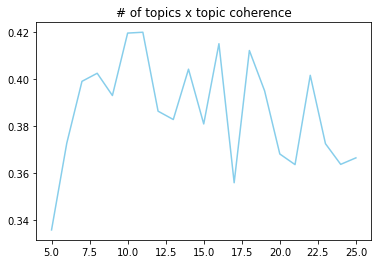


Number of topics: 11
Coherence Score: 0.4198



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.058326  0.147628       1        1  17.693451
4     -0.413202  0.106366       2        1  13.806737
9      0.179501  0.450913       3        1  10.787505
0     -0.128221 -0.223631       4        1  10.755689
1     -0.255593  0.360078       5        1   9.414248
7     -0.172045  0.020433       6        1   8.159253
3     -0.412592 -0.226811       7        1   6.981845
10     0.385835 -0.067547       8        1   6.301594
6      0.408525  0.247261       9        1   6.022670
2      0.005638 -0.510129      10        1   5.381410
8      0.343827 -0.304561      11        1   4.695597, topic_info=        Term          Freq         Total Category  logprob  loglift
55       age  32194.000000  32194.000000  Default  10.0000  10.0000
60      slot  33953.000000  33953.000000  Default   9.0000   9.0000
110     dose  50953.000000  50953.000000  Default   8.0000   8.0000
5     vaccin  74599.000000  74599.000000  Default   7.0000   7.0000
448  covaxin  18831.000000  18831.000000  Default   6.0000   6.0000
..       ...           ...           ...      ...      ...      ...
97    clinic   1985.743646   4864.006980  Topic11  -3.7284   2.1627
110     dose   3617.771234  50953.532034  Topic11  -3.1285   0.4135
57    hospit   1961.297413  12438.857179  Topic11  -3.7408   1.2113
979     road   1061.568116   2783.004555  Topic11  -4.3546   2.0948
443   apollo   1055.940222   5150.075086  Topic11  -4.3599   1.4740

[221 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
865      11  0.999209     accept
299       9  0.999494        add
55        3  0.999928        age
55        5  0.000062        age
1282      3  0.999328        ago
...     ...       ...        ...
353       4  0.803997       year
353       5  0.195907       year
184       1  0.999972  yesterday
137       5  0.000672        yet
137       7  0.998890        yet

[396 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 10, 1, 2, 8, 4, 11, 7, 3, 9])

In [ ]:
LDA_PATH = ROOT_PATH + 'lda/'

def model_coherence(corpus, dictionary, data, k, a='auto', b='auto'):
    start_time = time.time()
    lda_model = LdaModel(corpus=corpus,
                id2word=dictionary,
                num_topics=k, 
                random_state=100,
                chunksize=2000,
                alpha=a,
                eta=b)
    
    coherence_model = CoherenceModel(model=lda_model, texts=data, dictionary=dictionary, coherence='c_v')
    vis = gensimvis.prepare(lda_model, corpus, dictionary, mds="mmds", R=10)
    time_taken = time.time() - start_time
    return vis, coherence_model.get_coherence(), time_taken // 60, time_taken % 60


def lda(path, frac=1., start=5, topics=10):

    df = load_data(path).sample(frac=frac, random_state=100)

    # tokenize and clean data
    tokenized_tweets = [word_tokenize(tweet) for tweet in df['text']]

    # lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tweets = [[lemmatizer.lemmatize(token) for token in tweet] for tweet in tokenized_tweets] 

    # stemming
    stemmer = PorterStemmer()
    stemmed_tweets = [[stemmer.stem(token) for token in tweet] for tweet in lemmatized_tweets]  

    # bow,create a corpus from a list of texts
    dictionary = Dictionary(stemmed_tweets)
    corpus = [dictionary.doc2bow(text) for text in stemmed_tweets]

    # lda, train the model on the corpus.
    results = []
    for t in range(start,start + topics + 1):
        vis, coherence_lda, min, sec = model_coherence(corpus, dictionary, stemmed_tweets, t)
        print("Done for %2d topics, score: %.4f, time: %dmin%.2fsec" % (t, coherence_lda, min, sec))
        results.append((vis, t, coherence_lda))
        write_data(LDA_PATH + 'lda_result_' + str(t) + '_' + str(frac) + '.pkl', vis)
    

    results.sort(reverse=False, key=lambda x: x[1])
    line_plot([x[1] for x in results], [x[2] for x in results], '# of topics x topic coherence')

    results.sort(reverse=True, key=lambda x: x[2])
    print('\nNumber of topics: %d\nCoherence Score: %.4f\n' % (results[0][1], results[0][2]))
    
    return results[0][0]
  
pyLDAvis.enable_notebook()
lda(DATASETS + 'data_set_clean.pkl', topics=20)

# Question 6

## Fine tuning to find the best parameters for the classifiers

In [ ]:
def train(dataset_path, fraction = 0.01, cv = 10):
    
    df = load_data(dataset_path).sample(frac=fraction, random_state=100) 

    X = df['text'].values
    y = df['sentiment'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 101)

    bvec = fit_vectorizer(X_train, method=CountVectorizer)
    tfvec = fit_vectorizer(X_train, method=TfidfVectorizer)

    bow_train = transform_data(X_train, bvec)
    tf_idf_train = transform_data(X_train, tfvec)
    emb_train = prepare_emb(X_train, model_path=GLOVE + 'glove_200d.pkl')

    bow_test= transform_data(X_test, bvec)
    tf_idf_test = transform_data(X_test, tfvec)
    emb_test = prepare_emb(X_test, model_path=GLOVE + 'glove_200d.pkl')


    scoring = { 'accuracy' : make_scorer(accuracy_score), 
                'precision' : make_scorer(precision_score, average='micro'),
                'recall' : make_scorer(recall_score, average='micro'), 
                'f1_score' : make_scorer(f1_score, average='micro')
                }
                
    # default: C=1. gamma='scale', degree=3, kernel='rbf'
    param_grid_svm = [  {'C': [1., 10., 100., 200.], 'gamma': [0.001, 0.0001, 'scale'], 'kernel': ['rbf']},
                        {'C': [1., 10., 100., 200.], 'gamma': [0.001, 0.0001, 'scale'], 'degree': [3, 4, 5], 'kernel': ['poly']}                        
                    ]
    # default: max_depth=None, n_estimators=100, max_features='auto'
    param_grid_rf = [   {'max_depth': [10, 20, 40, 100], 'n_estimators': [10, 50, 100, 200, 500], 'max_features': ['auto', 'sqrt', 'log2']},                      
                    ]
    # default: n_neighborsint=5, p=2, weights='uniform'
    param_grid_knn = [  {'n_neighbors': [1, 3, 5, 10, 20], 'p': [1, 2], 'weights': ['uniform', 'distance']},               
                    ]
                    
    def fine_tune(clf, param_grid, X_train, y_train, X_test, y_test, cv=10, refit=True, scoring=None, verbose=0, message=''):
        start_time = time.time()

        # grid = GridSearchCV(clf, param_grid, cv=cv, refit=refit, scoring=scoring, verbose=verbose).fit(X_train, y_train)
        grid = RandomizedSearchCV(clf, param_grid, cv=cv, refit=refit, scoring=scoring, verbose=verbose, n_jobs=-1, n_iter=50).fit(X_train, y_train)

        to_print = (message + ' took') if message != '' else 'Took'
        print(to_print + ' %.2f seconds' % (time.time() - start_time))

        print(grid.best_params_)
        print(grid.best_estimator_)

        grid_predictions = grid.predict(X_test)
        print(classification_report(y_test, grid_predictions, zero_division=0))

    fine_tune(svm.SVC(), param_grid_svm, bow_train, y_train, bow_test, y_test, cv=cv, message='\nSVM BOW')
    fine_tune(svm.SVC(), param_grid_svm, tf_idf_train, y_train, tf_idf_test, y_test, cv=cv, message='\nSVM TF-IDF')
    fine_tune(svm.SVC(), param_grid_svm, emb_train, y_train, emb_test, y_test, cv=cv, message='\nSVM EMBEDDINGS')

    fine_tune(RandomForestClassifier(), param_grid_rf, bow_train, y_train, bow_test, y_test, cv=cv, message='\nRF BOW')
    fine_tune(RandomForestClassifier(), param_grid_rf, tf_idf_train, y_train, tf_idf_test, y_test, cv=cv, message='\nRF TF-IDF')
    fine_tune(RandomForestClassifier(), param_grid_rf, emb_train, y_train, emb_test, y_test, cv=cv, message='\nRF EMBEDDINGS')

    fine_tune(KNeighborsClassifier(), param_grid_knn, bow_train, y_train, bow_test, y_test, cv=cv, message='\nKNN BOW')
    fine_tune(KNeighborsClassifier(), param_grid_knn, tf_idf_train, y_train, tf_idf_test, y_test, cv=cv, message='\nKNN TF-IDF')
    fine_tune(KNeighborsClassifier(), param_grid_knn, emb_train, y_train, emb_test, y_test, cv=cv, message='\nKNN EMBEDDINGS')

In [ ]:
train(DATASETS + 'train.pkl', 0.05)


SVM BOW took 353.91 seconds
{'kernel': 'rbf', 'gamma': 'scale', 'C': 1.0}
SVC()
              precision    recall  f1-score   support

         NEG       0.92      0.13      0.23       246
         NEU       0.79      0.99      0.88      1365
         POS       0.84      0.27      0.40       215

    accuracy                           0.79      1826
   macro avg       0.85      0.46      0.50      1826
weighted avg       0.81      0.79      0.74      1826


SVM TF-IDF took 379.25 seconds
{'kernel': 'poly', 'gamma': 'scale', 'degree': 3, 'C': 1.0}
SVC(kernel='poly')
              precision    recall  f1-score   support

         NEG       0.82      0.13      0.22       246
         NEU       0.77      0.99      0.87      1365
         POS       0.76      0.13      0.23       215

    accuracy                           0.77      1826
   macro avg       0.78      0.42      0.44      1826
weighted avg       0.78      0.77      0.71      1826


SVM EMBEDDINGS took 553.01 seconds
{'kernel':

We notice that there for different methods of text vectorizing the parameters that yield the best results differ by a lot 

This is not wrong, since we essentially have different input each time and we cannot expect the same parameters to work the same despite that the tweets given are the same


We also notice that they differ a **lot** from the (almost) default we tried on Q4, which is also logical to happen 

We should note that although we did cross validation to meassure the performance of each parameter combination and it is indeed a good method to evaluate models when the data set is small, the parameters we found are the best for the given data set (a small fraction of the complete one) and they may differ from the best ones in general. 

The next step is to train the model that yields the best results on the complete training set and meassure its performance on the test set